## State Space Modeling of Team Strength in Football

We are interested in modeling team strength over the length of a season. The strength metric will not be static as it evolves over the course of the season due to factors such as injuries, confidence and the ability of opposition teams to figure out how to play against a team. Therefore we are interested in modeling team strength as a time series.

The data used in order to model team strength is betting data from the website https://www.bet365.com/en/

Game by game odds for all the leagues used to demonstrate the model were obtained from http://www.football-data.co.uk/

The model is an implementation of the paper presented here https://arxiv.org/pdf/1701.05976.pdf

From the accompanying blog post: 

"Moreso than wins and losses or point differential, perhaps the best game-level metric of team strength comes not in what happens during the game, but what’s known before the game begins. Indeed, it’s been shown time and again that there’s no better way to judge models in sports than to compare to betting market data. Prior to each contest, betting markets put out probabilities associated with each team winning. The reason this data is so accurate is that it takes into account all of the factors above – injuries, opponent strength, line-ups, tanking, etc."


## Model

Betting data comes in the form of weekly odds of a home win, draw or loss.

Let $y_{i,j,w} = logit ( p_{i,j,w} ) $ be the log odds of observed probability of a home win for team i against team j in week w.

We can model $ E [ logit (p_{i,j,w} ] = \theta_{i,w} - \theta_{j,w} + \alpha + \alpha_{Ti} $

where: 
$$
\begin{align}
\theta_{i,w} &: \text{team strength rating of team i in week w} \\
\theta_{j,w} &: \text{team strength rating of team j in week w} \\
\alpha &: \text{baseline home advtange for all teams} \\
\alpha_{Ti} &: \text{home advantage of team i}  \\
\\
\text{For any team i we can assume that the team strength in week w is given as follows:} \\
\theta_{i,w} & \sim N(\gamma\theta_{i, w-1}, \tau_{w}^2) \\
\text{where: }
\theta_{i,w-1} &: \text{team strength for team i in week w-1} \\
\gamma &: \text{autocorrelation at order 1 for team strength in week w} \\
\tau_{w} &: \text{week-level uncertainity in the evolution of team strength} \\
\end{align}
$$

## Implementation in Stan

## Some Helper Functions

In [2]:
import pystan

In [3]:
def logit(p):
    return np.log(p/(1-p))

In [23]:
def prepare_data(filename):
    
    df = pd.read_csv(filename, dayfirst = True)
    
    df = df[['Date', 'HomeTeam', 'AwayTeam', 'B365H', 'B365D', 'B365A']]
    
    df['p_home'] = (1/df['B365H']) 
    
    df['Date'] = pd.to_datetime(df['Date'], dayfirst = True)
    
    df['week'] = (np.floor((df['Date'] - df['Date'][0])/np.timedelta64(1, 'W'))).astype('int') + 1

    return df
    

In [99]:
def prepare_model_data(df):
    '''
    returns a dictionary that will be passed to the stan model
    '''
    
    model_data = {}
    
    Teams =  sorted(list(df['HomeTeam'].unique()))
    
    model_data['nteams'] = len(Teams)
    
    model_data['nweeks'] = max(df['week']) + 1
    
    model_data['n'] = len(df)
    model_data['ht'] = []
    
    X = np.zeros((len(Teams), df.shape[0]))
    
    for i in range(0, df.shape[0]):
        X[Teams.index(df.loc[i, 'HomeTeam']), i ] = 1
        X[Teams.index(df.loc[i, 'AwayTeam']), i] = -1
        model_data['ht'].append(Teams.index(df.loc[i, 'HomeTeam']) + 1)
        
    model_data['X'] = X  
    
    model_data['y'] = logit(df['p_home'])
    
    model_data['w'] = df['week'] 
    
    return model_data, Teams
    

In [6]:
def plot_params():
    return fit.plot(pars = ['alpha', 'gammaWeek'])

def plot_team_strengths(sample, l, Teams):
    plt.figure(figsize = (10,8))
    for i in l:
        id = Teams.index(i)
        plt.plot(sample['theta'][1000:, :, id].mean(axis = 0))
        plt.xlabel('Week')
        plt.ylabel('theta (log-odds scale)')
        plt.legend(l)


In [7]:
def get_results(filename, l):
    
    df = prepare_data(filename)
    model_data, Teams = prepare_model_data(df)
    
    fit = pystan.stan(model_code=data + parameters + transformed_params + model, data=model_data, iter=3000, warmup = 1000, chains=2)
    
    sample= fit.extract(permuted = True)
    plot_team_strengths(sample, l, Teams)
    
    return sample, Teams

In [8]:
def plot_final_rating(samples, Teams):
    
    x = samples['theta'][1000:][35:][:].mean(axis = 0).mean(axis=0)
    e = samples['theta'][1000:][35:][:].std(axis = 0).mean(axis=0)
    
    data = sorted(list(zip(x, Teams, e)), key = lambda x: x[0])
    x_val = [x[0] for x in data]
    e_val = [x[2] for x in data]
    Teams = [x[1] for x in data]
    
    y = np.linspace(-2.0, 2.0, len(x_val))
    x = x_val
    my_yticks = Teams
    plt.figure(figsize = (10,8))
    plt.yticks(y, my_yticks)
    plt.errorbar(x, y, xerr = e_val, fmt='o', color='black',
             ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel('Estimated Team Strength (log-odds scale)')
    plt.xlim(-1.5,2.5)
    plt.show()

## Stan Implementation

We need a matrix of dimensions W,N that contains the weekly strength rating for each team.

In [100]:
data = """
data {
    int<lower=0> n;      // total number of games
    int<lower=0> nweeks; // total number of weeks
    int<lower=0> nteams; // total number of teams
    int<lower=0> w[n]; 
    vector[n] y;        
    int<lower=0> ht[n];
    matrix[nteams, n] X; 
}
"""

In [101]:
parameters = """
parameters {
    real<lower = 0, upper=1> gammaWeek; // autoregressive coefficient
    real<lower = 0> tauSeason;  // uncertainty in team strength from season to season
    real<lower = 0> tauWeek; // uncertainty in team strength from week to week
    real<lower = 0> tauGame; // uncertainty in team strength from game to game
    real alpha; // baseline home strength
    vector[nteams] alphaTeam; // home strength for each team
    matrix[nweeks, nteams] theta;
}
"""

In [102]:
transformed_params = """
transformed parameters {
    vector[n] mu;
    for (i in 1:n) {
        mu[i] <- alpha + theta[w[i],:] * X[:,i] + alphaTeam[ht[i]];
    }
 }
"""

In [103]:
model = """
model { 
    alpha ~ normal(0.01, 0.005);
    gammaWeek ~ normal(0.9, 0.05);
    tauSeason ~ student_t(20, 0, 1);
    tauWeek ~ student_t(5, 0, 1);
    tauGame ~ student_t(5, 0, 1);
    
    y ~ normal(mu, tauGame);
    
    for (j in 1: nteams){
        alphaTeam ~ normal(0.1, 0.1);
    }
    for (j in 1:nteams){
        theta[1,j] ~ normal(0, tauSeason);
    }
    
    for (www in 2:nweeks) {  
        for (j in 1:nteams) {
            theta[www,j] ~ normal(gammaWeek*theta[www-1,j], tauWeek);
          }
  
     }
    }
"""

## Barclays Premier League Season 2017-18

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


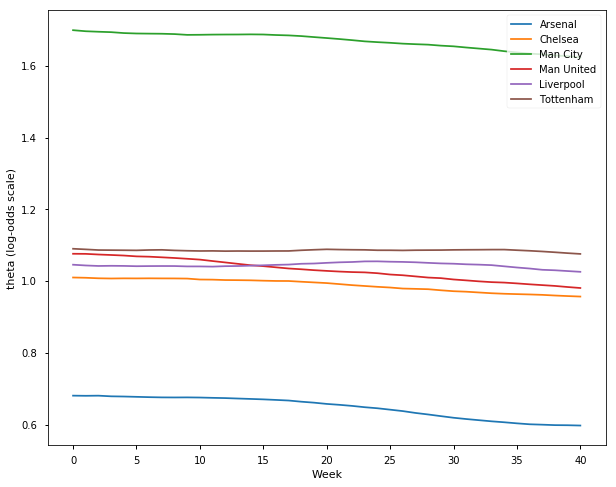

In [13]:
l = ['Arsenal', 'Chelsea', 'Man City', 'Man United', 'Liverpool', 'Tottenham']
## let's look at the weekly time series of team strengths for these six teams
samplesE1718, TeamsE1718 = get_results('E02017.csv', l)

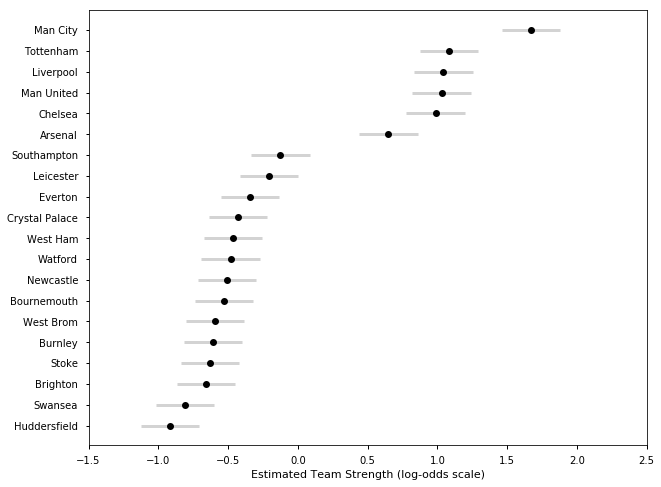

In [14]:
## Let's look at the estimated team strengths
plot_final_rating(samplesE1718, TeamsE1718)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


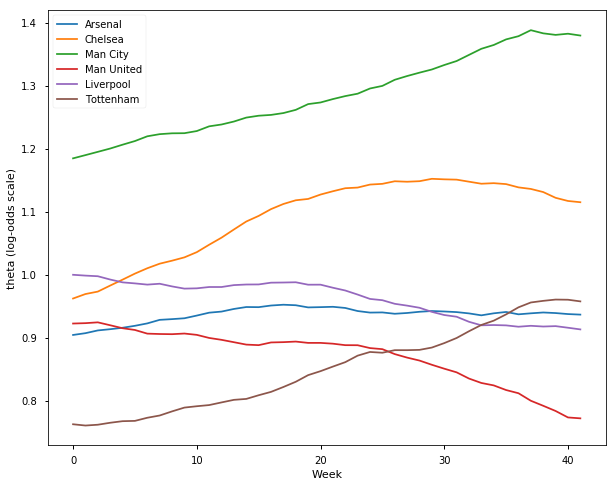

In [15]:
## Premier League Season 2016-17
samplesE1617, TeamsE1617 = get_results('E0201617.csv', l)

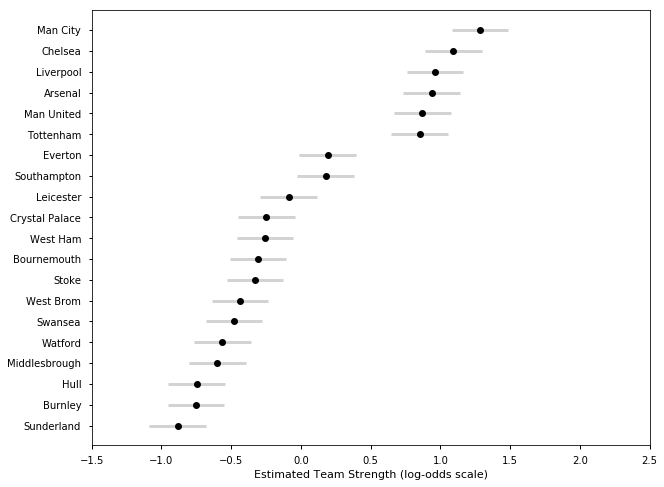

In [16]:
plot_final_rating(samplesE1617, TeamsE1617)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


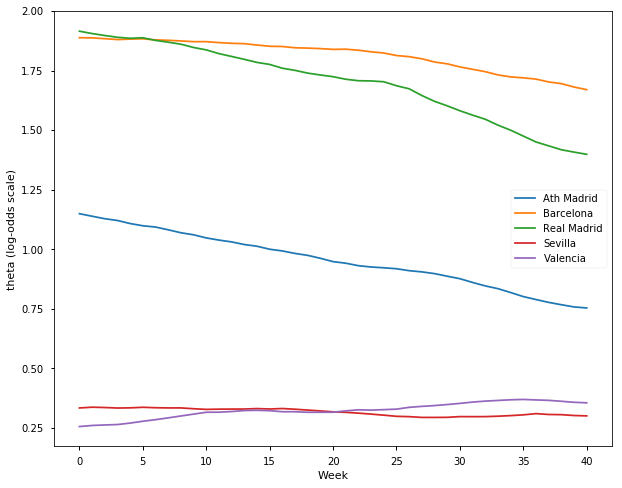

In [17]:
## Spanish La Liga Season 2017-18
l = ['Ath Madrid', 'Barcelona', 'Real Madrid', 'Sevilla', 'Valencia']
samplesS1718, TeamsS1718 = get_results('SP1718.csv', l)


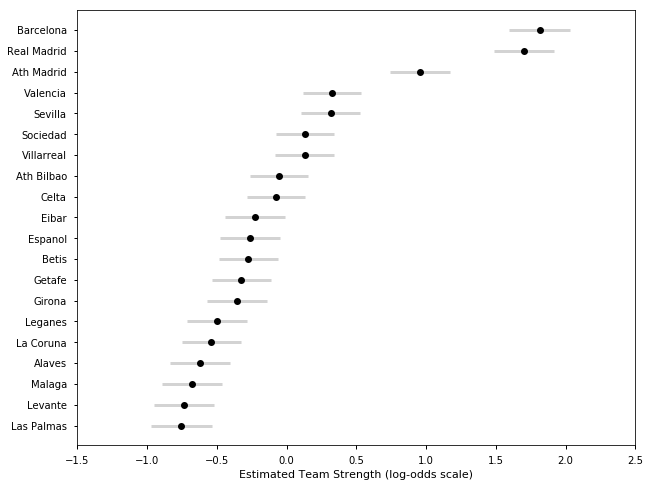

In [18]:
plot_final_rating(samplesS1718, TeamsS1718)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


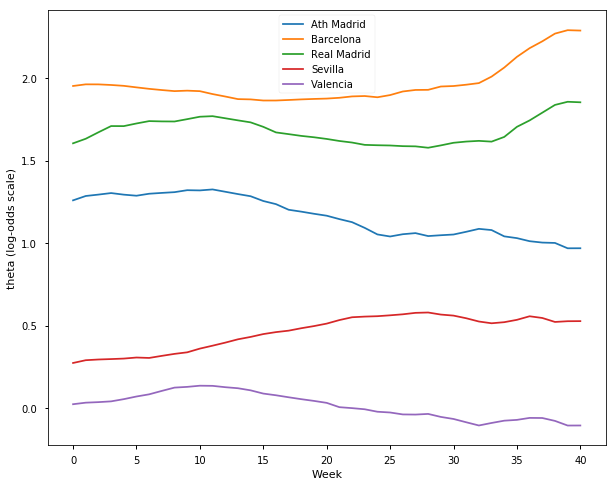

In [24]:
## Spanish La Liga Season 2016-17
samplesS1617, TeamsS1617 = get_results('SP1617.csv', l)

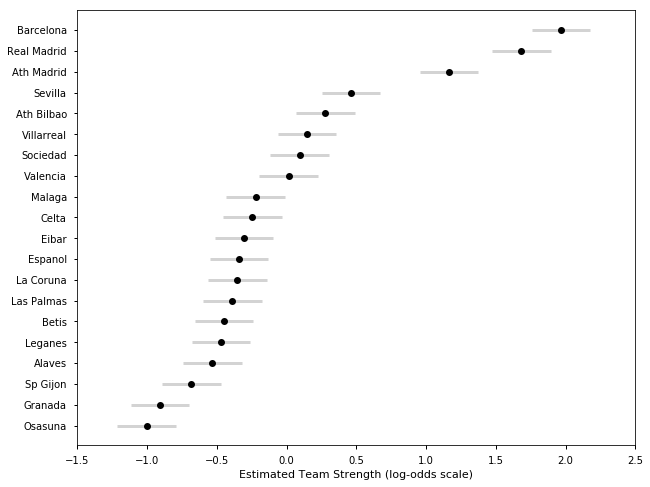

In [25]:
plot_final_rating(samplesS1617, TeamsS1617)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


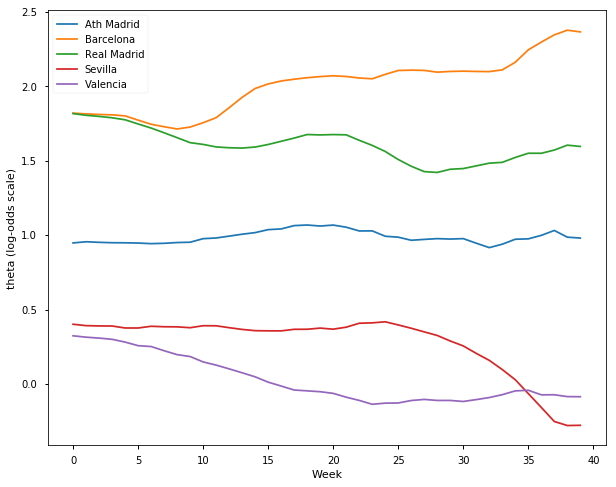

In [26]:
## Spanish La Liga Season 2015-16
samplesS1516, TeamsS1516 = get_results('SP201516.csv', l)

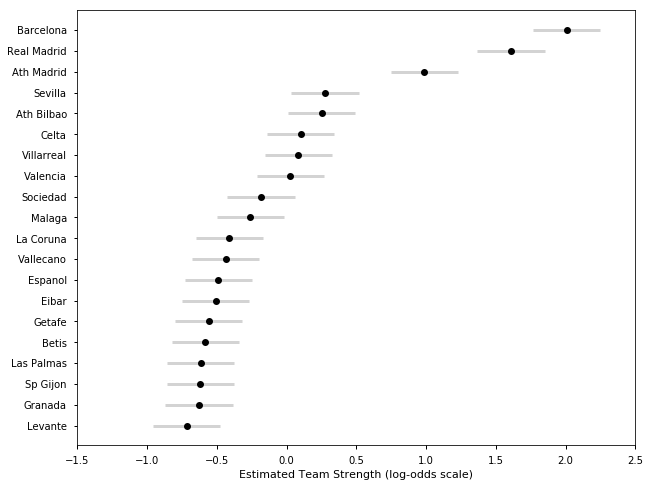

In [27]:
plot_final_rating(samplesS1516, TeamsS1516)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


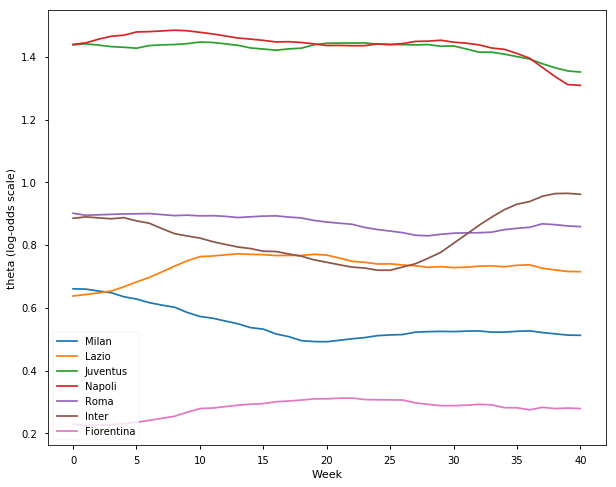

In [28]:
## Italian Serie-A Season 2017-18
l = ['Milan', 'Lazio', 'Juventus', 'Napoli', 'Roma', 'Inter', 'Fiorentina']
samplesI1718, TeamsI1718 = get_results('I201718.csv', l)

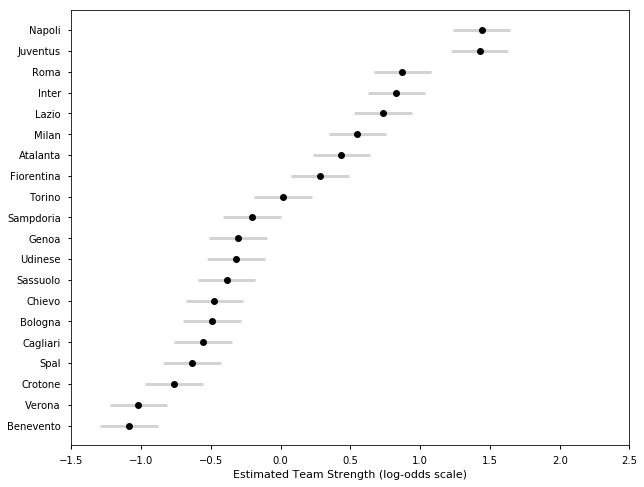

In [29]:
plot_final_rating(samplesI1718, TeamsI1718)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


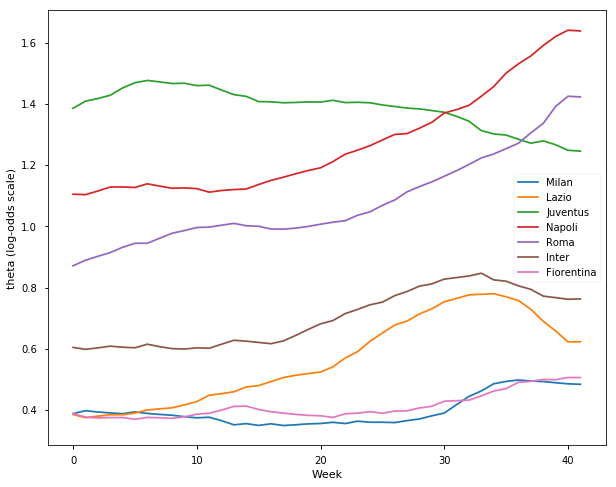

In [30]:
## Italian Serie A Season 2016-17
samplesI1617, TeamsI1617 = get_results('I201617.csv', l)

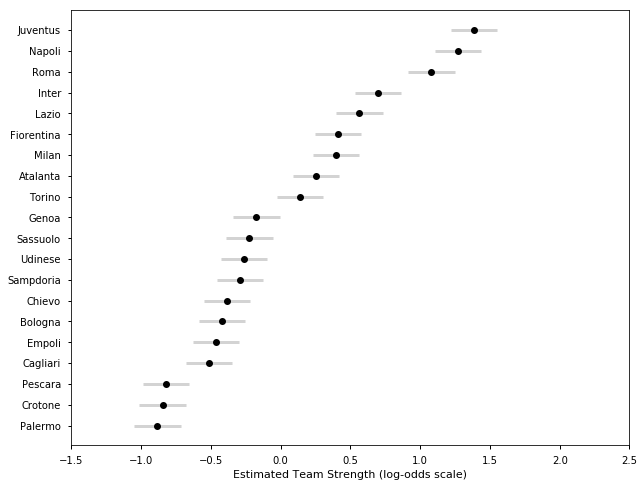

In [31]:
plot_final_rating(samplesI1617, TeamsI1617)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


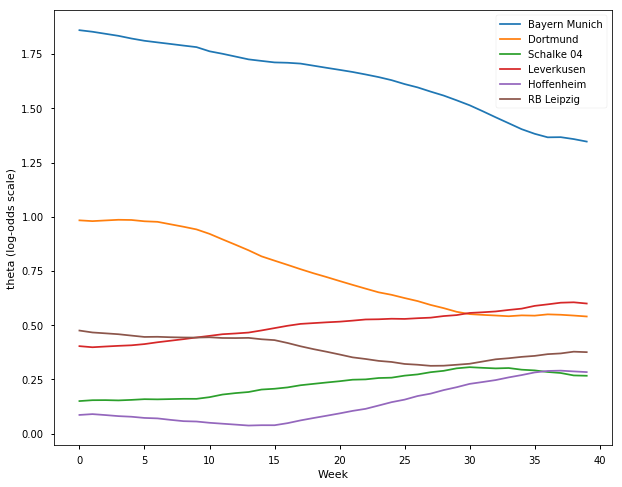

In [32]:
## German Bundesliga Season 2017-18
l = ['Bayern Munich', 'Dortmund', 'Schalke 04', 'Leverkusen', 'Hoffenheim', 'RB Leipzig']
samplesG1718, TeamsG1718 = get_results('G201718.csv', l)

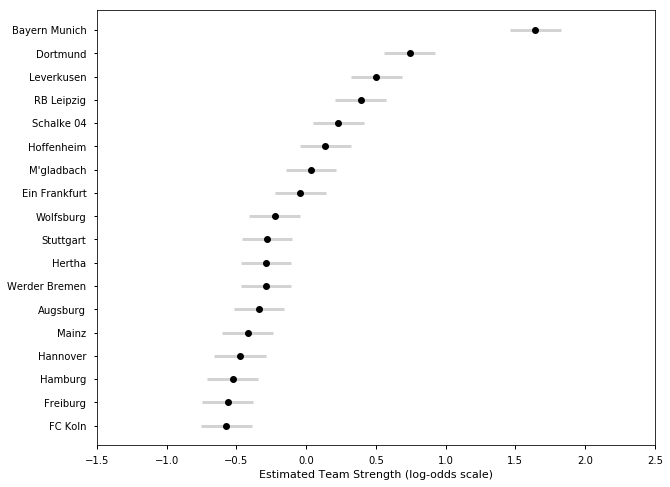

In [33]:
plot_final_rating(samplesG1718, TeamsG1718)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


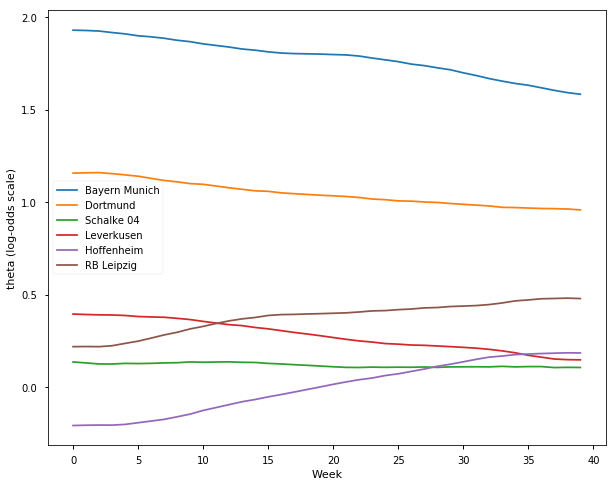

In [34]:
## German Bundesliga Season 2016-17
samplesG1617, TeamsG1617 = get_results('G201617.csv', l)

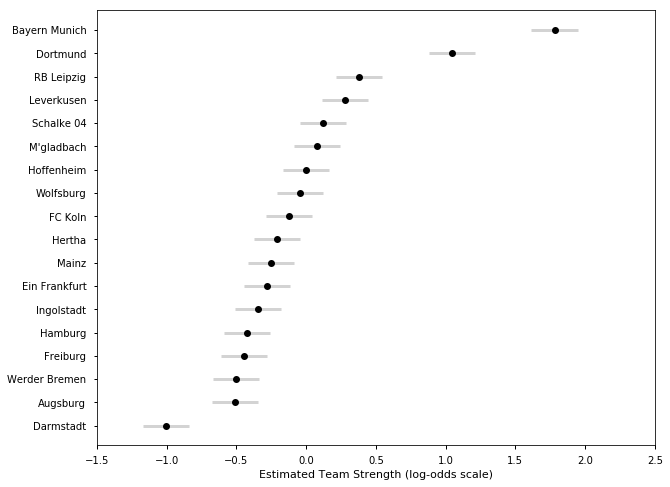

In [35]:
plot_final_rating(samplesG1617, TeamsG1617)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


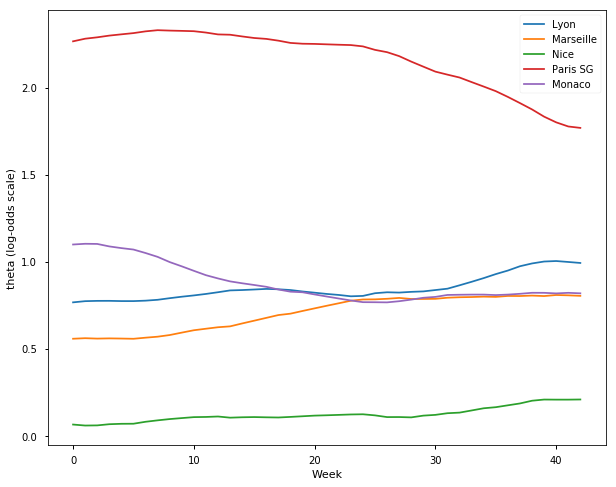

In [36]:
## French Ligue Un Season 2017-18
l = ['Lyon', 'Marseille', 'Nice', 'Paris SG', 'Monaco']
samplesF1718, TeamsF1718 = get_results('F201718.csv', l)

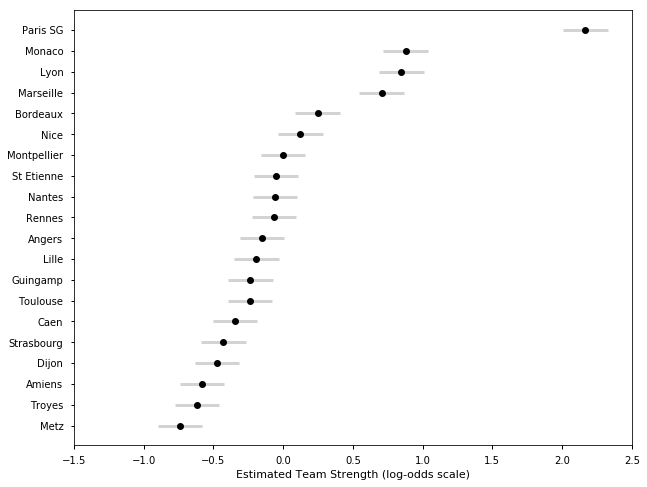

In [37]:
plot_final_rating(samplesF1718, TeamsF1718)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_7eab52f40be587905f219e2d7f11fcab NOW.


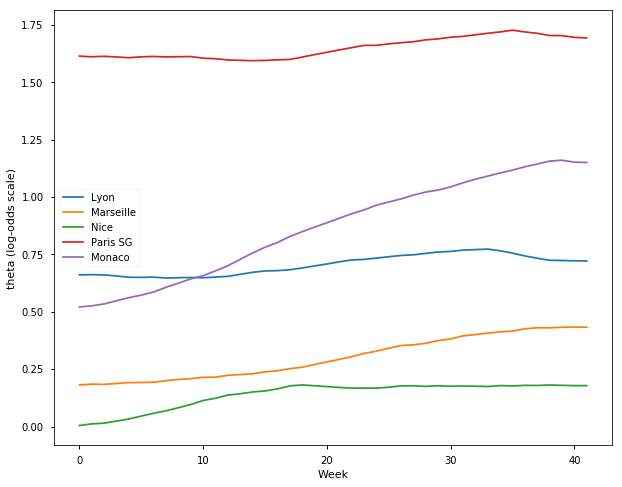

In [38]:
## French Ligue Un Season 2016-17
samplesF1617, TeamsF1617 = get_results('F201617.csv', l)

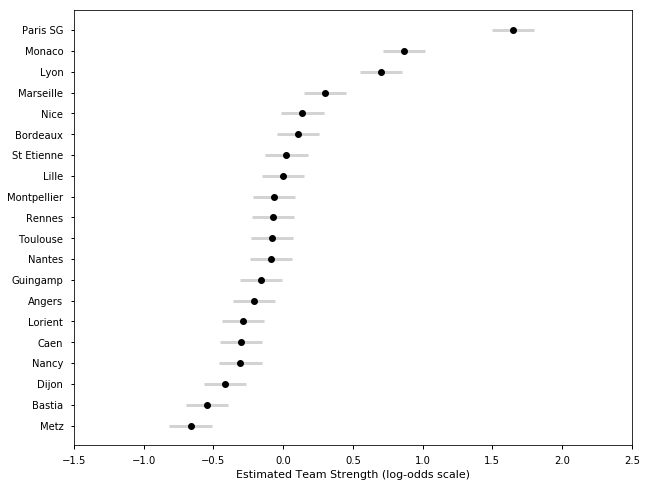

In [39]:
plot_final_rating(samplesF1617, TeamsF1617)

## Comparing Team Strength Across Leagues

In [95]:

def plot_comp_rating(s, Ts):
    
    plt.figure(figsize = (10,20))
    data = []
    for samples, Teams in zip(s, Ts):
        x = samples['theta'][1000:][35:][:].mean(axis = 0).mean(axis=0)
        e = samples['theta'][1000:][35:][:].std(axis = 0).mean(axis=0)

        data.extend(sorted(list(zip(x, Teams, e)), key = lambda x: x[0]))
    
    x_val = [x[0] for x in data]
    e_val = [x[2] for x in data]
    T = [x[1] for x in data]

    x = x_val
    y = np.linspace(-2, 2, len(data))
    my_yticks = T

    plt.yticks(y, my_yticks)
    plt.errorbar(x, y[:len(x_val)], xerr = e_val, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel('Estimated Team Strength 2016/17 (log-odds scale)')
    plt.xlim(-1.5,2.5)
    plt.savefig('TeamRating1617.png', dpi = 300, bbox_inches = 'tight')    
    plt.show()

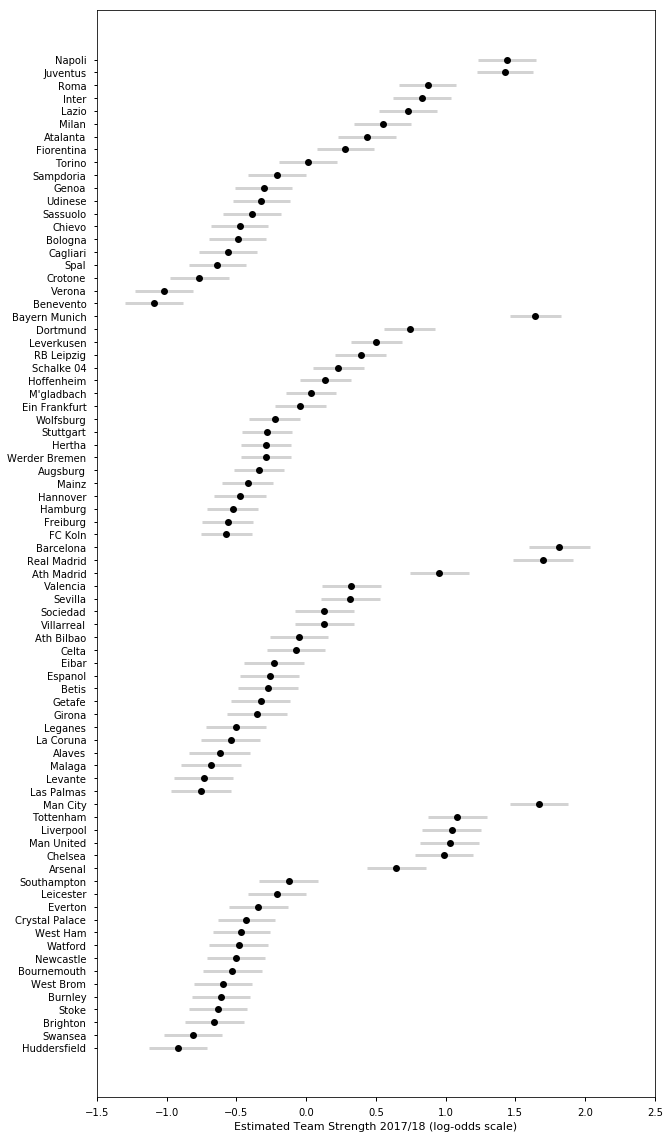

In [94]:
s = [samplesE1718, samplesS1718, samplesG1718, samplesI1718]
Ts = [TeamsE1718, TeamsS1718, TeamsG1718, TeamsI1718]

plot_comp_rating(s, Ts)

The plot above shows the team strength rating in the final week of the season. Plotting it in the way I have done above allows us to also compare competitiveness across leagues. It appears that the gap between the best and the worst teams is larger in Italy, Spain and Germany than in England. Teams 2-6 in England appear to be better than peers in all other leagues. The bottom 7 or 8 teams appear to be equally bad in all other leagues. The difference between the best and teams 2-6 in the Premier League is also more pronounced in 2017-18 than it used to be, considering Manchester City had a historic season recording 100 points. The plot below does the same for season 2016-17 and you can see that the difference is not as pronounced.

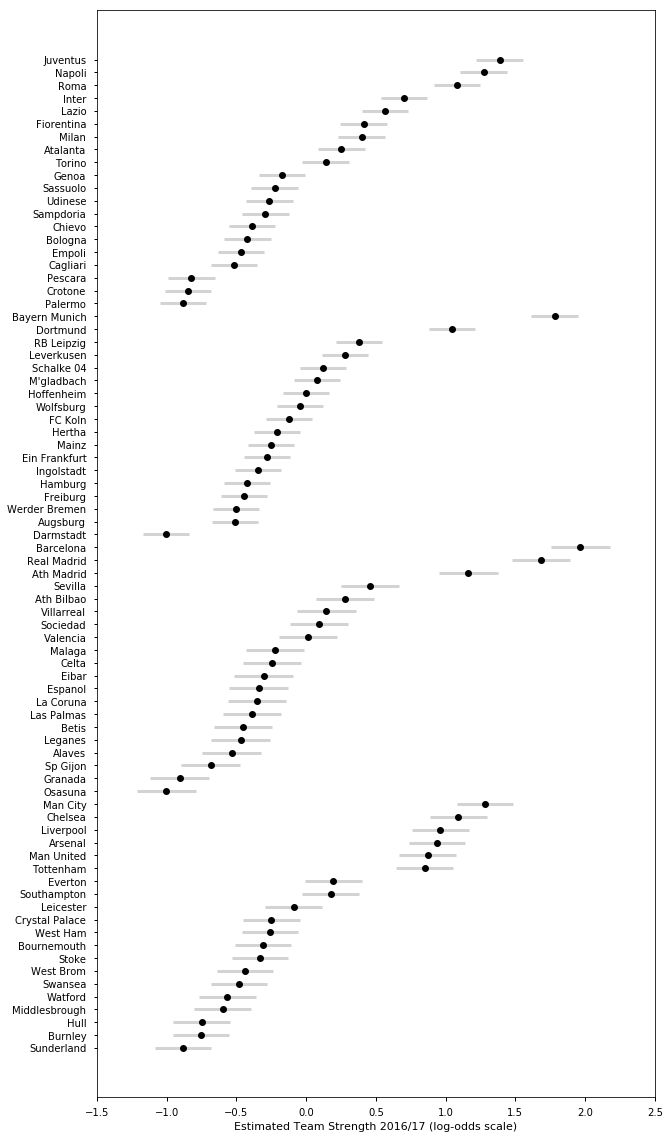

In [96]:
## Season 2016-17
s = [samplesE1617, samplesS1617, samplesG1617, samplesI1617]
Ts = [TeamsE1617, TeamsS1617, TeamsG1617, TeamsI1617]

plot_comp_rating(s, Ts)

## Comparing Home Advantage

In [78]:
def plot_home_adv(s, Ts):
    
    plt.figure(figsize = (10,18))
    data = []
    #plt.figure.tight_layout()
    for samples, Teams in zip(s, Ts):
        x = samples['alphaTeam'][1000:][:].mean(axis = 0) + samples['alpha'].mean(axis = 0)
        e = samples['alphaTeam'][1000:][:].std(axis = 0)

        data.extend(sorted(list(zip(x, Teams, e)), key = lambda x: x[0]))
    
    x_val = [x[0] for x in data]
    e_val = [x[2] for x in data]
    T = [x[1] for x in data]

    x = x_val
    y = np.linspace(-2, 2, len(data))
    my_yticks = T

    plt.yticks(y, my_yticks)
    plt.errorbar(x, y[:len(x_val)], xerr = e_val, fmt='o', color='black',
                 ecolor='lightgray', elinewidth=3, capsize=0)
    plt.xlabel('Estimated Home Advantage (log-odds scale)')
    plt.xlim(0.02,0.12)
    plt.savefig('1617HomeStrength.png', dpi = 300, bbox_inches = 'tight')    
    plt.show()
    

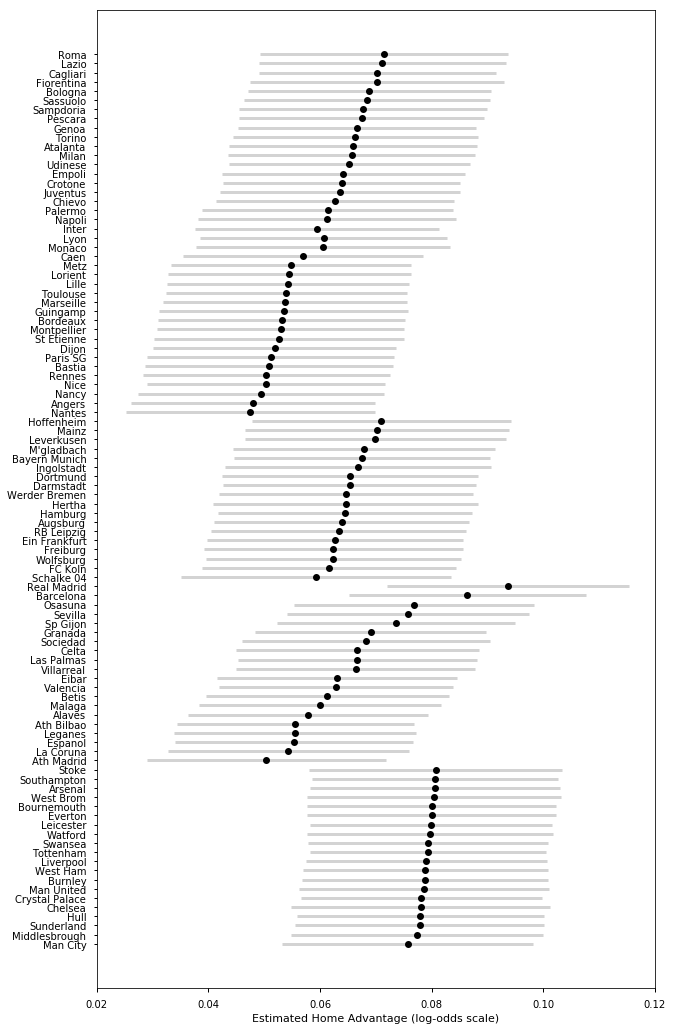

In [79]:
s = [samplesE1617, samplesS1617, samplesG1617, samplesF1617, samplesI1617]
Ts = [TeamsE1617, TeamsS1617, TeamsG1617, TeamsF1617, TeamsI1617]

plot_home_adv(s, Ts)

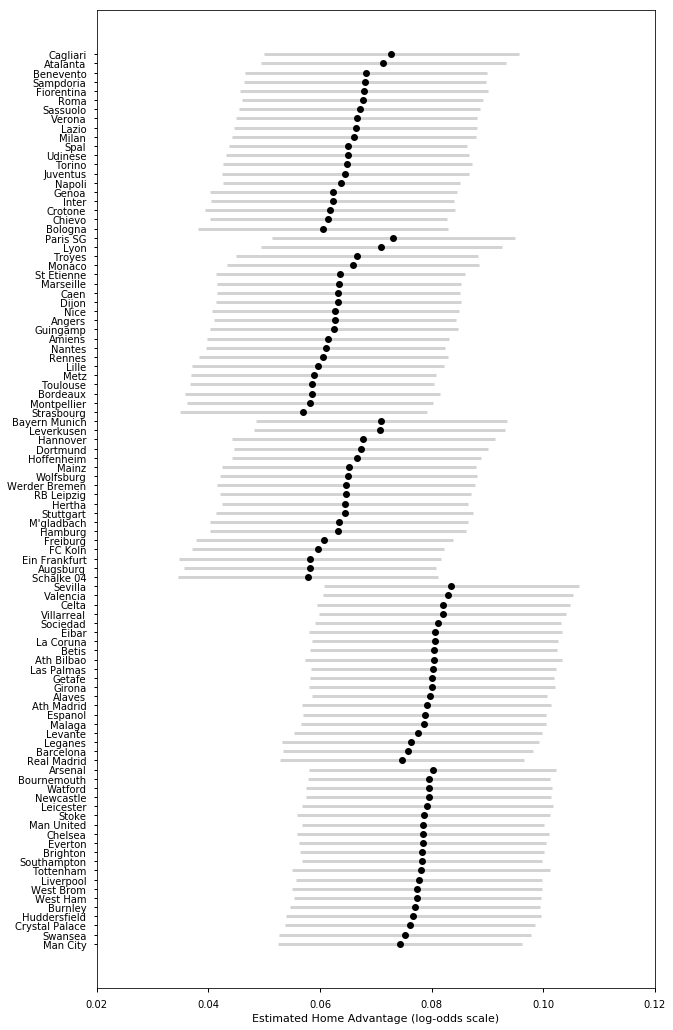

In [70]:
s = [samplesE1718, samplesS1718, samplesG1718, samplesF1718, samplesI1718]
Ts = [TeamsE1718, TeamsS1718, TeamsG1718, TeamsF1718, TeamsI1718]

plot_home_adv(s, Ts)

Looking at the above two plots, it appears there is a small home advantage. It is the highest in the English Premier League on average compared to the other leagues. This might explain why the Premier League is more competitive than the other leagues.